In [1]:
## sleep stage classification - 2 class - using SAX features
## PAA time window = 0.1s

# try :
# balance with smote / balanced class weight in SVM
# grid search + CV  -> show plots on train & val error
# optimise prob thres


## FINETUNING
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
# https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/
# GOOGLE: how to perform grid search from Svm in python
# https://scikit-learn.org/stable/modules/grid_search.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
# https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
# http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_parameters_selection.html


# http://localhost:8888/notebooks/Intern/Sleep_stage_Classification_2Class-imbalanced-data-SMOTE.ipynb
# http://localhost:8888/notebooks/GPU_run/EEG_Classification_CNN_full_SMOTE_diff_network_GPU.ipynb
# http://localhost:8888/notebooks/classification_2class_epochData_newPkl.ipynb

import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
import itertools
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.metrics import auc,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix
from sklearn.metrics import classification_report

In [2]:
###################function to plot confusion matrix#####################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
###########################################################################################

In [3]:
## load data ##

file_location='C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data' #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018'
os.chdir('C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data') #'/home/intern_eyecare/Desktop/EEG/raw_data') #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018')

# remove 2nd night of subject 13, as there was data loss - pkl file created accordingly
dfull = pickle.load(open('Frac_sax_dimer_0.1s_EEG_all_patients.pkl', 'rb'))
dfull.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,pID,day,epoch,class_label
0,0.110368,0.050167,0.016722,0.013378,0.066890,0.173913,0.060201,0.020067,0.010033,0.083612,0.163880,0.046823,0.003344,0.010033,0.063545,0.107023,400,1,s1e1,wake
1,0.090301,0.040134,0.020067,0.016722,0.050167,0.210702,0.080268,0.010033,0.020067,0.096990,0.170569,0.030100,0.006689,0.003344,0.046823,0.107023,400,1,s1e2,wake
2,0.130435,0.043478,0.003344,0.000000,0.040134,0.210702,0.053512,0.023411,0.006689,0.070234,0.167224,0.030100,0.000000,0.003344,0.050167,0.167224,400,1,s1e3,wake
3,0.123746,0.083612,0.030100,0.006689,0.050167,0.073579,0.076923,0.033445,0.050167,0.050167,0.110368,0.066890,0.020067,0.023411,0.060201,0.140468,400,1,s1e4,wake
4,0.100334,0.073579,0.050167,0.000000,0.046823,0.060201,0.096990,0.033445,0.056856,0.076923,0.133779,0.080268,0.020067,0.026756,0.063545,0.080268,400,1,s1e5,wake


In [4]:
### check the data ###
# 1. look for null values
dfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92994 entries, 0 to 92993
Data columns (total 20 columns):
0              92994 non-null float64
1              92994 non-null float64
2              92994 non-null float64
3              92994 non-null float64
4              92994 non-null float64
5              92994 non-null float64
6              92994 non-null float64
7              92994 non-null float64
8              92994 non-null float64
9              92994 non-null float64
10             92994 non-null float64
11             92994 non-null float64
12             92994 non-null float64
13             92994 non-null float64
14             92994 non-null float64
15             92994 non-null float64
pID            92994 non-null object
day            92994 non-null object
epoch          92994 non-null object
class_label    92994 non-null object
dtypes: float64(16), object(4)
memory usage: 14.2+ MB


In [5]:
dfull.isnull().sum()

0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
pID            0
day            0
epoch          0
class_label    0
dtype: int64

In [6]:
# 2. check data distribution
dfull.groupby('class_label').size()

class_label
sleep_stage_1     2804
sleep_stage_2    17799
wake             72391
dtype: int64

In [7]:
### convert from 3-class to 2-class ###
dfull['class2'] = dfull['class_label']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

## convert selected columns to string/categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
dfull[['class_label']] = dfull[['class_label']].astype('str')        # ,'class2'

In [ ]:
### create training & test sets ###

In [8]:
### by patient ID  ###
ID = dfull['pID'].unique() # create ID list

np.random.seed(456)   ## select the IDs for the 2 sets
msk = np.random.rand(len(ID)) < 0.8
trainIDs = pd.DataFrame()
testIDs = pd.DataFrame()
trainIDs['pID'] = ID[msk]
testIDs['pID'] = ID[~msk]
print(trainIDs['pID'].tolist())
print(testIDs['pID'].tolist())


Train = dfull.loc[dfull['pID'].isin(ID[msk])] # create the train-test sets
Test = dfull.loc[dfull['pID'].isin(ID[~msk])] #
print(Train.shape)
print(Test.shape)
## also, check the distribution of class 0 & 1 in the train & test sets
print('Train distribution')
print(Train.groupby('class2').size())
print('')
print('Test distribution')
print(Test.groupby('class2').size())


X_train1 = Train.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()  ## create X & y splits
X_test = Test.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
y_train1 = Train['class2'].reset_index()
y_test = Test['class2'].reset_index()
X_train1 = X_train1.drop(['index'], 1)
X_test = X_test.drop(['index'],1)
y_train1 = y_train1.drop(['index'],1)
y_test = y_test.drop(['index'],1)

['400', '401', '402', '404', '405', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419']
['403', '406']
(82992, 21)
(10002, 21)
Train distribution
class2
0    64350
1    18642
dtype: int64

Test distribution
class2
0    8041
1    1961
dtype: int64


In [ ]:
'''
### by random sampling ###
X =  dfull.drop(['pID','day','epoch','class_label','class2'], 1) # dfull[['delta','theta','alpha','beta','gamma']]
y =  dfull['class2'] 

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  #stratify=y) #stratify=True

# to test if split is stratified
y_tr = pd.DataFrame(y_train1)
y_ts = pd.DataFrame(y_test)
print('')
print(y_tr.groupby('class2').size())
print('')
print(y_ts.groupby('class2').size())
'''

In [9]:
'''
## upsample training set
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train1, y_train1)
'''

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
'''
check_upsample = pd.DataFrame(y_train)
check_upsample.columns = ['class2']
#check_upsample.head(2)
print(check_upsample.groupby('class2').size())'''

class2
0    64350
1    64350
dtype: int64


In [9]:
### data scaling ###
from sklearn.preprocessing import StandardScaler  #, MinMaxScaler, RobustScaler
# http://benalexkeen.com/feature-scaling-with-scikit-learn/
# standardscaler: suitable for normally distributed data
# minMaxScaler: (x-min)/(max - min)

## normalize the data  : can also use other scalers 
scaler = StandardScaler()  #MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled.shape

In [ ]:
## -----------------------------------------------------------------------------------------##

In [10]:
### SVC model + probability thresholding ###
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-17 15:52:07


In [11]:
model_svc = SVC(probability=True)  #, class_weight='balanced')
model_svc.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [12]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2019-02-17 16:12:48'

In [13]:
# predict on test data - check metrics
y_pred = model_svc.predict(X_test_scaled)
#y_pred = model_svc.predict_proba(X_test_scaled)

In [14]:
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [16]:
model_svc.predict_proba(X_test_scaled)
# predict_proba gives you the probabilities for the target (0 and 1 in your case) in array form. 
# The number of probabilities for each row is equal to the number of categories in target variable (2 in your case)

array([[0.91816743, 0.08183257],
       [0.88149838, 0.11850162],
       [0.93192105, 0.06807895],
       ...,
       [0.38423833, 0.61576167],
       [0.36523312, 0.63476688],
       [0.23656296, 0.76343704]])

In [17]:
model_svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [19]:
y_pred = model_svc.predict_proba(X_test_scaled)[:,[1]]  ## prob for class 1

In [21]:
# vary threshold & get metrics

cut_off=np.arange(0,1,.01)

metric = []
#sensitivity=[]
#specificity=[]
for m in cut_off:
    array=np.zeros(len(y_pred))
    array_ind=[i for i in range(len(y_pred)) if y_pred[i]>=m]
    array[array_ind]=1
    p=precision_recall_fscore_support(y_test,array) 
    sensitivity = p[1][1]  # sensitivity.append(p[1][1])
    specificity = p[1][0]  # specificity.append(p[1][0])
    metric.append([m,sensitivity, specificity])
#sensitivity=pd.DataFrame(np.array(sensitivity))
#specificity=pd.DataFrame(np.array(specificity))
metric = pd.DataFrame(metric,columns=['thres', 'sensitivity', 'specificity'])

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.9635398985604184

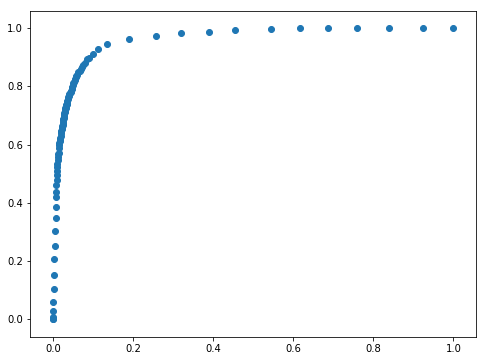

In [51]:
plt.figure(figsize=(8,6))
plt.scatter(x=1-pd.np.array(metric.iloc[:,[2]]),y=pd.np.array(metric.iloc[:,[1]]))
auc(1-pd.np.array(metric.iloc[:,[2]]),pd.np.array(metric.iloc[:,[1]]))

In [25]:
metric['FPR'] = 1 - metric['specificity']
#print(metric)
metric.head(50)

,thres,sensitivity,specificity,FPR
0,0.00,1.000000,0.000000,1.000000
1,0.01,1.000000,0.075115,0.924885
2,0.02,1.000000,0.161174,0.838826
3,0.03,1.000000,0.241388,0.758612
4,0.04,1.000000,0.314140,0.685860
5,0.05,0.999490,0.383907,0.616093
6,0.06,0.997450,0.455665,0.544335
7,0.07,0.994391,0.544833,0.455167
8,0.08,0.988271,0.609626,0.390374
9,0.09,0.982662,0.681383,0.318617


In [26]:
metric.tail(51)

,thres,sensitivity,specificity,FPR
49,0.49,0.726160,0.968909,0.031091
50,0.50,0.725140,0.969531,0.030469
51,0.51,0.718511,0.970277,0.029723
52,0.52,0.715961,0.970899,0.029101
53,0.53,0.711882,0.971272,0.028728
54,0.54,0.708312,0.971894,0.028106
55,0.55,0.702193,0.972516,0.027484
56,0.56,0.698623,0.973013,0.026987
57,0.57,0.693014,0.973138,0.026862
58,0.58,0.688424,0.974008,0.025992


In [29]:
# Youden index = x at which max(sensitivity + (1-specificity))  ## CORRECT FORMULA ??
optimal_idx = np.argmax(pd.np.array(metric['sensitivity']) - pd.np.array(metric['FPR']))
optimal_threshold = cut_off[optimal_idx]
print(optimal_threshold)

0.13


In [30]:
y_pred_thres = np.where(y_pred > optimal_threshold, 1, 0)

Confusion matrix, without normalization
[[7143  898]
 [ 143 1818]]
Normalized confusion matrix
[[0.89 0.11]
 [0.07 0.93]]


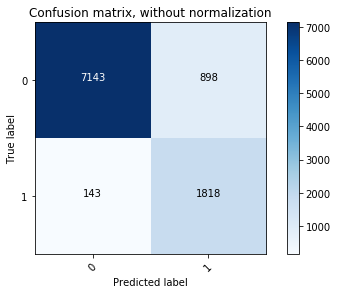

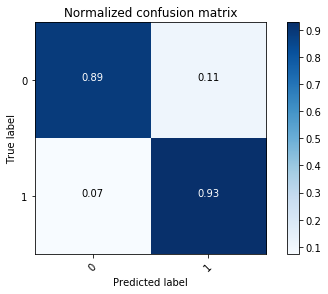

In [31]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred_thres)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [32]:
print(classification_report(y_test, y_pred_thres, target_names=class_names))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      8041
           1       0.67      0.93      0.78      1961

   micro avg       0.90      0.90      0.90     10002
   macro avg       0.82      0.91      0.85     10002
weighted avg       0.92      0.90      0.90     10002



In [16]:
print(accuracy_score(y_test,y_pred))

0.9221155768846231


In [33]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred_thres) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

(array([0.98, 0.67]),
 array([0.89, 0.93]),
 array([0.93, 0.78]),
 array([8041, 1961], dtype=int64))

In [35]:
p = precision_recall_fscore_support(y_test,y_pred_thres) 
sen = p[1][1]
spec = p[1][0]
print('sen: ' + str(sen) +' , spec: ' + str(spec))

sen: 0.9270780214176441 , spec: 0.8883223479666709


In [36]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_test, y_pred)

In [46]:
df = pd.DataFrame()
df = pd.concat([df,pd.DataFrame(thresholds), pd.DataFrame(p), pd.DataFrame(r)], axis=1)
df.columns = ['threshold', 'precision', 'recall']

In [47]:
df.describe()

,threshold,precision,recall
count,7038.000000,7039.000000,7039.000000
mean,0.283734,0.589286,0.819589
std,0.316557,0.235817,0.269004
min,0.047526,0.278014,0.000000
25%,0.075978,0.367451,0.753442
50%,0.107782,0.535674,0.964814
75%,0.413427,0.833662,0.991586
max,0.980143,1.000000,1.000000


In [49]:
df[ (df['precision'] == df['recall'] ) ] 

,threshold,precision,recall
5090,0.305779,0.800612,0.800612


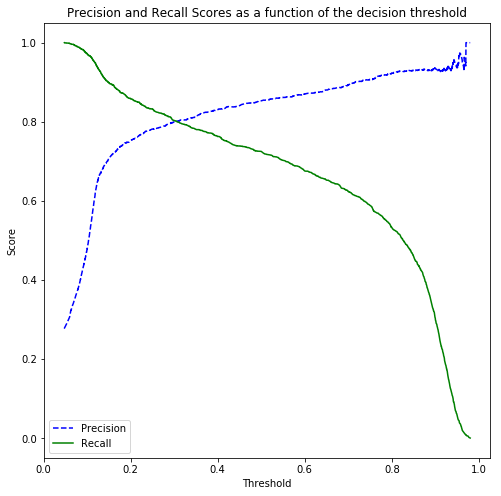

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Threshold")
    plt.legend(loc='best')

plot_precision_recall_vs_threshold(p, r, thresholds)

In [50]:
#y_pred_thres = np.where(y_pred > optimal_threshold, 1, 0)
y_pred_thres2 = np.where(y_pred > 0.306, 1, 0)
print(classification_report(y_test, y_pred_thres2, target_names=class_names))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8041
           1       0.80      0.80      0.80      1961

   micro avg       0.92      0.92      0.92     10002
   macro avg       0.88      0.88      0.88     10002
weighted avg       0.92      0.92      0.92     10002



Normalized confusion matrix
[[0.95 0.05]
 [0.2  0.8 ]]


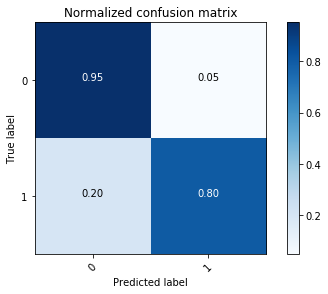

In [53]:
cnf_matrix = confusion_matrix(y_test, y_pred_thres2)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [56]:
###  cross-validation + Thresholding ###

from sklearn.metrics import make_scorer,recall_score,accuracy_score,precision_score   #roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold   # train_test_split,

clf = SVC() #n_jobs=-1)  # this runs the computation in parallel

param_grid = [
  #{'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
]


scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


skf = StratifiedKFold(n_splits=4)  # n_splits=10
grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit='recall_score',
                           cv=skf, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train1)  #X_train.values, y_train.values)

grid_search.best_params_
#best_C=grid_search.best_params_['C']
#best_gamma=grid_search.best_params_['gamma']

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [57]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-17 22:38:57


In [58]:
refit_score = 'recall_score'
print('Best params for {}'.format(refit_score))

Best params for recall_score


In [59]:
grid_search.cv_results_

{'mean_fit_time': array([ 858.83,  118.63,  123.8 , 1250.38,  191.69,   99.22, 1568.42,
         512.91,   96.23]),
 'std_fit_time': array([ 61.78,   8.54,   6.56,  87.97,  23.85,   2.65, 151.08,  43.99,
         11.67]),
 'mean_score_time': array([201.41,  56.88,  71.66, 165.15,  57.38,  59.43, 164.59,  54.12,
         44.83]),
 'std_score_time': array([17.09,  2.58,  2.27,  9.78,  1.86,  4.05, 15.76,  1.98,  7.37]),
 'param_C': masked_array(data=[0.1, 0.1, 0.1, 1, 1, 1, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[1, 0.1, 0.01, 1, 0.1, 0.01, 1, 0.1, 0.01],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf',
                    'rbf'],


In [60]:
## job started around 8 or 8:30 PM
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-17 23:14:39


In [61]:
model_svc = SVC(probability=True, C= 10, gamma= 0.1, kernel= 'rbf')  #, class_weight='balanced')
model_svc.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [62]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 00:11:22


In [63]:
y_pred = model_svc.predict_proba(X_test_scaled)[:,[1]]  ## prob for class 1

In [64]:
# vary threshold & get metrics

cut_off=np.arange(0,1,.01)

metric = []
#sensitivity=[]
#specificity=[]
for m in cut_off:
    array=np.zeros(len(y_pred))
    array_ind=[i for i in range(len(y_pred)) if y_pred[i]>=m]
    array[array_ind]=1
    p=precision_recall_fscore_support(y_test,array) 
    sensitivity = p[1][1]  # sensitivity.append(p[1][1])
    specificity = p[1][0]  # specificity.append(p[1][0])
    metric.append([m,sensitivity, specificity])
#sensitivity=pd.DataFrame(np.array(sensitivity))
#specificity=pd.DataFrame(np.array(specificity))
metric = pd.DataFrame(metric,columns=['thres', 'sensitivity', 'specificity'])

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.9555280525907479

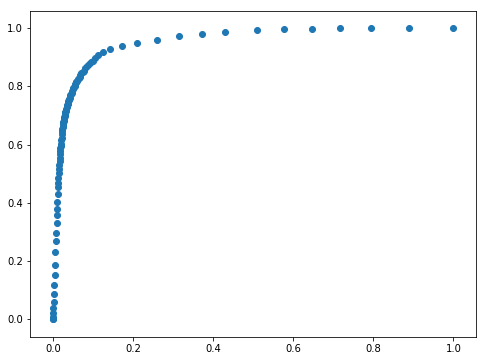

In [65]:
plt.figure(figsize=(8,6))
plt.scatter(x=1-pd.np.array(metric.iloc[:,[2]]),y=pd.np.array(metric.iloc[:,[1]]))
auc(1-pd.np.array(metric.iloc[:,[2]]),pd.np.array(metric.iloc[:,[1]]))

In [66]:
metric['FPR'] = 1 - metric['specificity']
#print(metric)
metric.head(50)

,thres,sensitivity,specificity,FPR
0,0.00,1.000000,0.000000,1.000000
1,0.01,1.000000,0.109937,0.890063
2,0.02,1.000000,0.206193,0.793807
3,0.03,1.000000,0.283796,0.716204
4,0.04,0.998470,0.354558,0.645442
5,0.05,0.995411,0.423455,0.576545
6,0.06,0.992861,0.490735,0.509265
7,0.07,0.985212,0.570203,0.429797
8,0.08,0.979602,0.628156,0.371844
9,0.09,0.972463,0.686731,0.313269


In [67]:
metric.tail(51)

,thres,sensitivity,specificity,FPR
49,0.49,0.732789,0.965925,0.034075
50,0.50,0.727690,0.966298,0.033702
51,0.51,0.722081,0.967666,0.032334
52,0.52,0.715961,0.968909,0.031091
53,0.53,0.713412,0.969407,0.030593
54,0.54,0.707292,0.969904,0.030096
55,0.55,0.702703,0.970775,0.029225
56,0.56,0.699643,0.971148,0.028852
57,0.57,0.695054,0.972143,0.027857
58,0.58,0.686894,0.972516,0.027484


In [68]:
optimal_idx = np.argmax(pd.np.array(metric['sensitivity']) - pd.np.array(metric['FPR']))
optimal_threshold = cut_off[optimal_idx]
print(optimal_threshold)

y_pred_thres = np.where(y_pred > optimal_threshold, 1, 0)

0.15


Normalized confusion matrix
[[0.89 0.11]
 [0.09 0.91]]


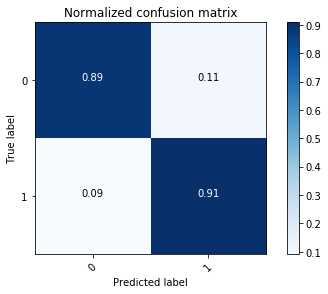

In [69]:
cnf_matrix = confusion_matrix(y_test, y_pred_thres)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [70]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred_thres) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

(array([0.98, 0.67]),
 array([0.89, 0.91]),
 array([0.93, 0.77]),
 array([8041, 1961], dtype=int64))

In [ ]:
##########  SVC model + class weight balancing #####W#

In [10]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 08:27:15


In [11]:
model_svc = SVC(class_weight='balanced')  # probability=True
model_svc.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [12]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 08:30:53


In [13]:
# predict on test data - check metrics
y_pred = model_svc.predict(X_test_scaled)

Normalized confusion matrix
[[0.88 0.12]
 [0.06 0.94]]


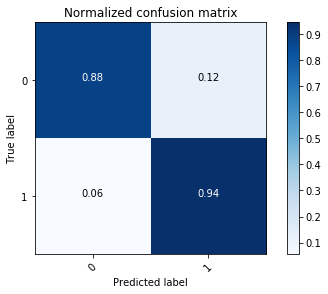

In [15]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [17]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

(array([0.98, 0.66]),
 array([0.88, 0.94]),
 array([0.93, 0.78]),
 array([8041, 1961], dtype=int64))

In [18]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      8041
           1       0.66      0.94      0.78      1961

   micro avg       0.89      0.89      0.89     10002
   macro avg       0.82      0.91      0.85     10002
weighted avg       0.92      0.89      0.90     10002



In [19]:
### balanced classweight + grid parameters ####
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 08:43:48


In [20]:
model_svc = SVC(C= 10, gamma= 0.1, kernel= 'rbf', class_weight='balanced')  # probability=True,
model_svc.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 08:53:10


In [22]:
# predict on test data - check metrics
y_pred = model_svc.predict(X_test_scaled)

In [23]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

(array([0.98, 0.67]),
 array([0.89, 0.92]),
 array([0.93, 0.77]),
 array([8041, 1961], dtype=int64))

In [ ]:
####  balanced class weight + grid param + prob thres  ####

In [24]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 10:22:08


In [25]:
model_svc_bl = SVC(C= 10, gamma= 0.1, kernel= 'rbf', class_weight='balanced', probability=True)
model_svc_bl.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 11:25:04


In [27]:
y_pred = model_svc_bl.predict_proba(X_test_scaled)[:,[1]]  ## prob for class 1

In [28]:
# vary threshold & get metrics

cut_off=np.arange(0,1,.01)

metric = []
#sensitivity=[]
#specificity=[]
for m in cut_off:
    array=np.zeros(len(y_pred))
    array_ind=[i for i in range(len(y_pred)) if y_pred[i]>=m]
    array[array_ind]=1
    p=precision_recall_fscore_support(y_test,array) 
    sensitivity = p[1][1]  # sensitivity.append(p[1][1])
    specificity = p[1][0]  # specificity.append(p[1][0])
    metric.append([m,sensitivity, specificity])
#sensitivity=pd.DataFrame(np.array(sensitivity))
#specificity=pd.DataFrame(np.array(specificity))
metric = pd.DataFrame(metric,columns=['thres', 'sensitivity', 'specificity'])

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
metric['FPR'] = 1 - metric['specificity']

optimal_idx = np.argmax(pd.np.array(metric['sensitivity']) - pd.np.array(metric['FPR']))
optimal_threshold = cut_off[optimal_idx]
print(optimal_threshold)

y_pred_thres = np.where(y_pred > optimal_threshold, 1, 0)

0.23


Normalized confusion matrix
[[0.87 0.13]
 [0.06 0.94]]


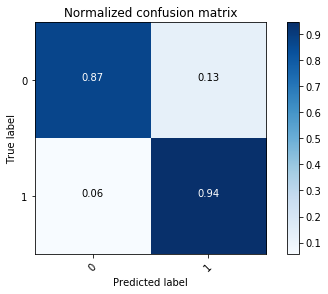

In [30]:
cnf_matrix = confusion_matrix(y_test, y_pred_thres)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [31]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred_thres) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

(array([0.98, 0.64]),
 array([0.87, 0.94]),
 array([0.92, 0.76]),
 array([8041, 1961], dtype=int64))

In [32]:
#print(metric)
metric.head(51)

,thres,sensitivity,specificity,FPR
0,0.00,1.000000,0.000000,1.000000
1,0.01,0.998470,0.372093,0.627907
2,0.02,0.996430,0.528044,0.471956
3,0.03,0.995411,0.609501,0.390499
4,0.04,0.995411,0.661361,0.338639
5,0.05,0.992861,0.698048,0.301952
6,0.06,0.989801,0.725532,0.274468
7,0.07,0.986741,0.752891,0.247109
8,0.08,0.983172,0.767442,0.232558
9,0.09,0.981642,0.781744,0.218256


In [33]:
metric.tail(50)

,thres,sensitivity,specificity,FPR
50,0.50,0.815400,0.937819,0.062181
51,0.51,0.802142,0.940803,0.059197
52,0.52,0.793473,0.942171,0.057829
53,0.53,0.785314,0.943788,0.056212
54,0.54,0.778174,0.946275,0.053725
55,0.55,0.767976,0.948514,0.051486
56,0.56,0.757777,0.950255,0.049745
57,0.57,0.746558,0.952493,0.047507
58,0.58,0.732789,0.954359,0.045641
59,0.59,0.714431,0.955976,0.044024


In [10]:
### grid with balanced class weight + prob thres ###

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-18 16:23:19


In [11]:
###  cross-validation + Thresholding ###

from sklearn.metrics import make_scorer,recall_score,accuracy_score,precision_score   #roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold   # train_test_split,

clf = SVC(class_weight='balanced') #n_jobs=-1)  # this runs the computation in parallel

param_grid = [
  #{'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear']},
  {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [10, 1, 0.1, 0.01], 'kernel': ['rbf']},
]


scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


skf = StratifiedKFold(n_splits = 5)  # n_splits=10
grid_search_clf = GridSearchCV(clf, param_grid, scoring=scorers, refit='recall_score',
                           cv=skf, return_train_score=True, n_jobs=-1)
grid_search_clf.fit(X_train_scaled, y_train1)  #X_train.values, y_train.values)

grid_search_clf.best_params_
#best_C=grid_search.best_params_['C']
#best_gamma=grid_search.best_params_['gamma']

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

In [12]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-19 04:10:12


In [13]:
grid_search_clf.cv_results_

{'mean_fit_time': array([ 673.69555831,  926.94002604,  342.59578667,  352.15751996,
         691.20266767,  861.3811944 ,  273.97967997,  266.95343995,
        2163.10079942, 1669.61949687,  283.02768002,  233.27304006,
        1646.34659595, 1932.25929132,  622.58352008,  204.94031997,
        1588.59204822, 2053.47229328, 3505.03482819,  428.87905602]),
 'std_fit_time': array([ 59.13483953,  70.86545357,  25.73665423,  25.3001152 ,
         21.62264112,  36.80910174,  43.73018794,  24.34436772,
        161.09469949,  99.97605386,  16.73672641,  19.79075691,
         97.88199808, 203.68784761,  73.63239091,   5.06728151,
        101.30986955,  39.87542777, 483.85710665,  42.95918608]),
 'mean_score_time': array([211.10914063, 191.93174934,  80.28949761,  83.34143996,
        211.57858896, 178.13109818,  64.96775999,  66.72744007,
        205.0032496 , 147.43438406,  56.06639996,  59.58023624,
        205.31659689, 138.8102015 ,  55.23648   ,  60.15672002,
        201.56847672, 137.11

In [20]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_gamma', 'param_kernel', 'params',
       'split0_test_precision_score', 'split1_test_precision_score',
       'split2_test_precision_score', 'split3_test_precision_score',
       'split4_test_precision_score', 'mean_test_precision_score',
       'std_test_precision_score', 'rank_test_precision_score',
       'split0_train_precision_score', 'split1_train_precision_score',
       'split2_train_precision_score', 'split3_train_precision_score',
       'split4_train_precision_score', 'mean_train_precision_score',
       'std_train_precision_score', 'split0_test_recall_score',
       'split1_test_recall_score', 'split2_test_recall_score',
       'split3_test_recall_score', 'split4_test_recall_score',
       'mean_test_recall_score', 'std_test_recall_score',
       'rank_test_recall_score', 'split0_train_recall_score',
       'split1_train_recall_score', 'split2_train_recall_score',
       's

In [27]:
results[['param_C','param_gamma']]

,param_C,param_gamma
0,0.01,10
1,0.01,1
2,0.01,0.1
3,0.01,0.01
4,0.1,10
5,0.1,1
6,0.1,0.1
7,0.1,0.01
8,1,10
9,1,1


In [28]:
acc = results[['param_C','param_gamma','mean_train_precision_score','mean_test_precision_score']]
print(acc)
# # the 6th point {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

   param_C param_gamma  mean_train_precision_score  mean_test_precision_score
0     0.01          10                    0.000000                   0.000000
1     0.01           1                    0.842514                   0.292848
2     0.01         0.1                    0.635673                   0.631831
3     0.01        0.01                    0.631811                   0.634471
4      0.1          10                    0.740513                   0.000000
5      0.1           1                    0.452765                   0.390622
6      0.1         0.1                    0.637262                   0.625838
7      0.1        0.01                    0.637210                   0.634368
8        1          10                    0.998848                   0.000000
9        1           1                    0.943791                   0.699166
10       1         0.1                    0.646561                   0.623946
11       1        0.01                    0.630998              

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  This is separate from the ipykernel package so we can avoid doing imports until


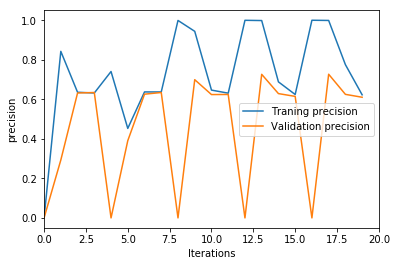

In [23]:
# dataframe & plots
fig, ax2 = plt.subplots(1, 1)
ax2.hold(True)

ax2.plot(acc['mean_train_precision_score'],label='Traning precision')
ax2.plot(acc['mean_test_precision_score'],label='Validation precision')
#ax2.set_title("Training and Validation precision")
ax2.set_ylabel("precision")
ax2.set_xlabel("Iterations")
ax2.set_xlim([0,20])
ax2.legend(fancybox=True)
# the 6th point {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}, was chosen by code as the best value

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  This is separate from the ipykernel package so we can avoid doing imports until


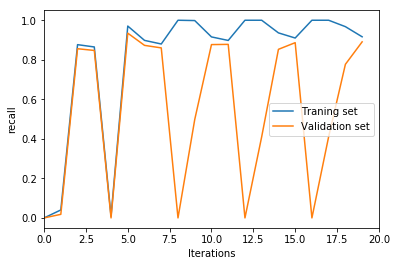

In [24]:
# dataframe & plots
fig, ax2 = plt.subplots(1, 1)
ax2.hold(True)

ax2.plot(results['mean_train_recall_score'],label='Traning set')
ax2.plot(results['mean_test_recall_score'],label='Validation set')
#ax2.set_title("Training and Validation precision")
ax2.set_ylabel("recall")
ax2.set_xlabel("Iterations")
ax2.set_xlim([0,20])
ax2.legend(fancybox=True)
# the 6th point {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}, was chosen by code as the best value

In [29]:
print(results[['param_C','param_gamma','mean_train_recall_score','mean_test_recall_score']])
# # the 6th point {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

   param_C param_gamma  mean_train_recall_score  mean_test_recall_score
0     0.01          10                 0.000000                0.000000
1     0.01           1                 0.040271                0.018079
2     0.01         0.1                 0.876515                0.855916
3     0.01        0.01                 0.864848                0.847173
4      0.1          10                 0.009012                0.000000
5      0.1           1                 0.970564                0.934664
6      0.1         0.1                 0.898106                0.872920
7      0.1        0.01                 0.879841                0.860100
8        1          10                 1.000000                0.000000
9        1           1                 0.998391                0.497799
10       1         0.1                 0.915674                0.876836
11       1        0.01                 0.897825                0.877963
12      10          10                 1.000000                0

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  This is separate from the ipykernel package so we can avoid doing imports until


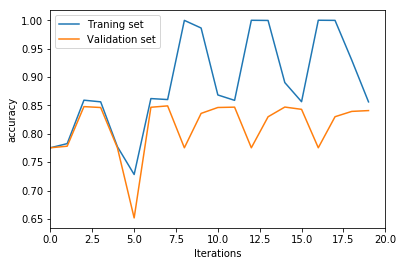

In [30]:
# dataframe & plots
fig, ax2 = plt.subplots(1, 1)
ax2.hold(True)

ax2.plot(results['mean_train_accuracy_score'],label='Traning set')
ax2.plot(results['mean_test_accuracy_score'],label='Validation set')
#ax2.set_title("Training and Validation precision")
ax2.set_ylabel("accuracy")
ax2.set_xlabel("Iterations")
ax2.set_xlim([0,20])
ax2.legend(fancybox=True)
# the 6th point {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}, was chosen by code as the best value

In [31]:
print(results[['param_C','param_gamma','mean_train_accuracy_score','mean_test_accuracy_score']])
# the 6th point {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

   param_C param_gamma  mean_train_accuracy_score  mean_test_accuracy_score
0     0.01          10                   0.775376                  0.775376
1     0.01           1                   0.782648                  0.778087
2     0.01         0.1                   0.859158                  0.847829
3     0.01        0.01                   0.856245                  0.846250
4      0.1          10                   0.777238                  0.775352
5      0.1           1                   0.728257                  0.651774
6      0.1         0.1                   0.861996                  0.846696
7      0.1        0.01                   0.860264                  0.849118
8        1          10                   0.999741                  0.775328
9        1           1                   0.986279                  0.835876
10       1         0.1                   0.868355                  0.846286
11       1        0.01                   0.858884                  0.846889
12      10  

In [32]:
print(results[['param_C','param_gamma','mean_train_recall_score','mean_test_recall_score','mean_train_accuracy_score','mean_test_accuracy_score','mean_train_precision_score','mean_test_precision_score']])
# the 6th point {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
# look at rows: 2,3, 6,7, 10,11,15,19

# previous run had selected: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

   param_C param_gamma  mean_train_recall_score  mean_test_recall_score  \
0     0.01          10                 0.000000                0.000000   
1     0.01           1                 0.040271                0.018079   
2     0.01         0.1                 0.876515                0.855916   
3     0.01        0.01                 0.864848                0.847173   
4      0.1          10                 0.009012                0.000000   
5      0.1           1                 0.970564                0.934664   
6      0.1         0.1                 0.898106                0.872920   
7      0.1        0.01                 0.879841                0.860100   
8        1          10                 1.000000                0.000000   
9        1           1                 0.998391                0.497799   
10       1         0.1                 0.915674                0.876836   
11       1        0.01                 0.897825                0.877963   
12      10          10   

In [40]:
acc = results[['param_C','param_gamma','mean_train_recall_score','mean_test_recall_score','mean_train_accuracy_score','mean_test_accuracy_score','mean_train_precision_score','mean_test_precision_score']] 
acc = acc.iloc[[2,3,5,6,7,10,11,15,19],]
acc

,param_C,param_gamma,mean_train_recall_score,mean_test_recall_score,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_precision_score,mean_test_precision_score
2,0.01,0.1,0.876515,0.855916,0.859158,0.847829,0.635673,0.631831
3,0.01,0.01,0.864848,0.847173,0.856245,0.846250,0.631811,0.634471
5,0.1,1,0.970564,0.934664,0.728257,0.651774,0.452765,0.390622
6,0.1,0.1,0.898106,0.872920,0.861996,0.846696,0.637262,0.625838
7,0.1,0.01,0.879841,0.860100,0.860264,0.849118,0.637210,0.634368
10,1,0.1,0.915674,0.876836,0.868355,0.846286,0.646561,0.623946
11,1,0.01,0.897825,0.877963,0.858884,0.846889,0.630998,0.624438
15,10,0.01,0.910055,0.886492,0.856507,0.843045,0.624301,0.614734
19,100,0.01,0.916291,0.890676,0.856209,0.840840,0.622695,0.610369


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  This is separate from the ipykernel package so we can avoid doing imports until


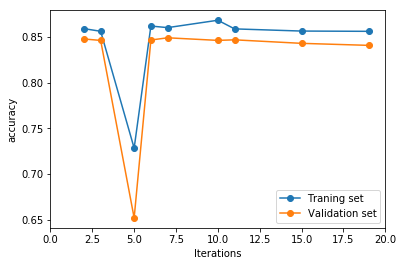

In [42]:
# dataframe & plots
fig, ax2 = plt.subplots(1, 1)
ax2.hold(True)

ax2.plot(acc['mean_train_accuracy_score'],label='Traning set', marker='o')
ax2.plot(acc['mean_test_accuracy_score'],label='Validation set', marker = 'o')
#ax2.set_title("Training and Validation precision")
ax2.set_ylabel("accuracy")
ax2.set_xlabel("Iterations")
ax2.set_xlim([0,20])
ax2.legend(fancybox=True)
# the 6th point {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}, was chosen by code as the best value

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  This is separate from the ipykernel package so we can avoid doing imports until


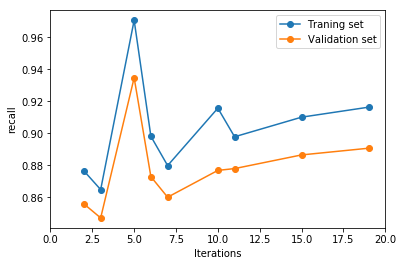

In [43]:
# dataframe & plots
fig, ax2 = plt.subplots(1, 1)
ax2.hold(True)

ax2.plot(acc['mean_train_recall_score'],label='Traning set', marker='o')
ax2.plot(acc['mean_test_recall_score'],label='Validation set', marker = 'o')
#ax2.set_title("Training and Validation precision")
ax2.set_ylabel("recall")
ax2.set_xlabel("Iterations")
ax2.set_xlim([0,20])
ax2.legend(fancybox=True)
# the 6th point {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}, was chosen by code as the best value

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  This is separate from the ipykernel package so we can avoid doing imports until


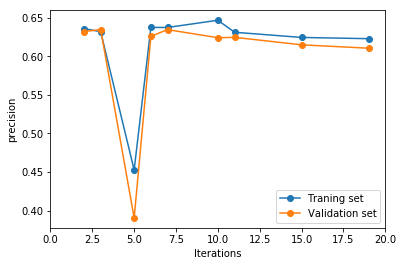

In [44]:
# dataframe & plots
fig, ax2 = plt.subplots(1, 1)
ax2.hold(True)

ax2.plot(acc['mean_train_precision_score'],label='Traning set', marker='o')
ax2.plot(acc['mean_test_precision_score'],label='Validation set', marker = 'o')
#ax2.set_title("Training and Validation precision")
ax2.set_ylabel("precision")
ax2.set_xlabel("Iterations")
ax2.set_xlim([0,20])
ax2.legend(fancybox=True)
# the 6th point {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}, was chosen by code as the best value

In [14]:
y_pred_grid = grid_search_clf.predict(X_test_scaled) #X_test.values)

In [16]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred_grid) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

(array([0.98750932, 0.40836567]),
 array([0.65874891, 0.96583376]),
 array([0.79030213, 0.57402637]),
 array([8041, 1961], dtype=int64))

Normalized confusion matrix
[[0.66 0.34]
 [0.03 0.97]]


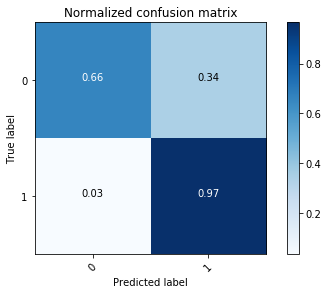

In [19]:
class_names = ['0','1']
cnf_matrix = confusion_matrix(y_test, y_pred_grid)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [33]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-19 10:06:03


In [34]:
# SVC model on train data with optimised param
model_svc1 = SVC(C= 0.1, gamma= 1, kernel= 'rbf', class_weight='balanced')  # probability=True,
model_svc1.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [35]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-19 10:18:54


In [48]:
y_pred = model_svc1.predict(X_test_scaled) #X_test.values)

In [49]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred) 

(array([0.99, 0.41]),
 array([0.66, 0.97]),
 array([0.79, 0.57]),
 array([8041, 1961], dtype=int64))

In [50]:
print(accuracy_score(y_test,y_pred))

0.7189562087582484


In [ ]:
## choosing a different set of hyper-parameters

In [45]:
model_svc2 = SVC(C= 1, gamma= 0.01, kernel= 'rbf', class_weight='balanced')  # probability=True,
model_svc2.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
#import pickle
pickle.dump(model_svc2, open("C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/code/sax_frac_0.1s_noSMOTE_optimisation_svc2.pkl", 'wb'))

In [46]:
y_pred = model_svc2.predict(X_test_scaled) #X_test.values)
precision_recall_fscore_support(y_test,y_pred) 

(array([0.98, 0.68]),
 array([0.89, 0.93]),
 array([0.94, 0.79]),
 array([8041, 1961], dtype=int64))

In [47]:
print(accuracy_score(y_test,y_pred))

0.9006198760247951


In [51]:
# diff param
model_svc3 = SVC(C= 10, gamma= 0.01, kernel= 'rbf', class_weight='balanced')  # probability=True,
model_svc3.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [52]:
y_pred = model_svc3.predict(X_test_scaled) #X_test.values)
precision_recall_fscore_support(y_test,y_pred) 

(array([0.98, 0.66]),
 array([0.88, 0.94]),
 array([0.93, 0.78]),
 array([8041, 1961], dtype=int64))

In [53]:
print(accuracy_score(y_test,y_pred))

0.8942211557688462


In [ ]:
###################################################################################

In [54]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-19 12:27:04


In [55]:
# SVC model on train data with optimised param  (these are the params selected by grid search in line 11
#     - but they give bad results here - why?)
model_svc4 = SVC(probability=True, C= 0.1, gamma= 1, kernel= 'rbf', class_weight='balanced')
model_svc4.fit(X_train_scaled, y_train1)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [56]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2019-02-19 14:01:29


In [65]:
y_pred = model_svc4.predict(X_test_scaled) #X_test.values)
precision_recall_fscore_support(y_test,y_pred) 

(array([0.99, 0.41]),
 array([0.66, 0.97]),
 array([0.79, 0.57]),
 array([8041, 1961], dtype=int64))

In [66]:
print(accuracy_score(y_test,y_pred))

0.7189562087582484


Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


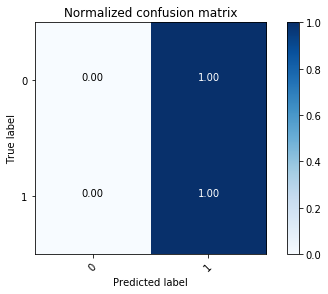

In [67]:
cnf_matrix = confusion_matrix(y_test, y_pred_thres)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [68]:
cnf_matrix

array([[   0, 8041],
       [   0, 1961]], dtype=int64)

In [57]:
y_pred = model_svc4.predict_proba(X_test_scaled)[:,[1]]  ## prob for class 1

In [58]:
# vary threshold & get metrics

cut_off=np.arange(0,1,.01)

metric = []
#sensitivity=[]
#specificity=[]
for m in cut_off:
    array=np.zeros(len(y_pred))
    array_ind=[i for i in range(len(y_pred)) if y_pred[i]>=m]
    array[array_ind]=1
    p=precision_recall_fscore_support(y_test,array) 
    sensitivity = p[1][1]  # sensitivity.append(p[1][1])
    specificity = p[1][0]  # specificity.append(p[1][0])
    metric.append([m,sensitivity, specificity])
#sensitivity=pd.DataFrame(np.array(sensitivity))
#specificity=pd.DataFrame(np.array(specificity))
metric = pd.DataFrame(metric,columns=['thres', 'sensitivity', 'specificity'])

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.09852463797692616

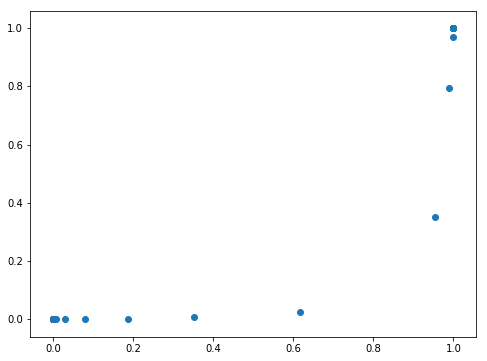

In [59]:
plt.figure(figsize=(8,6))
plt.scatter(x=1-pd.np.array(metric.iloc[:,[2]]),y=pd.np.array(metric.iloc[:,[1]]))
auc(1-pd.np.array(metric.iloc[:,[2]]),pd.np.array(metric.iloc[:,[1]]))

In [60]:
metric['FPR'] = 1 - metric['specificity']

optimal_idx = np.argmax(pd.np.array(metric['sensitivity']) - pd.np.array(metric['FPR']))
optimal_threshold = cut_off[optimal_idx]
print(optimal_threshold)

y_pred_thres = np.where(y_pred > optimal_threshold, 1, 0)

0.0


Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


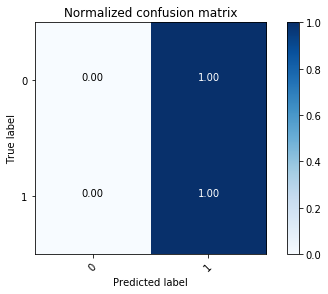

In [61]:
cnf_matrix = confusion_matrix(y_test, y_pred_thres)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [62]:
#from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred_thres) 

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0. , 0.2]),
 array([0., 1.]),
 array([0.  , 0.33]),
 array([8041, 1961], dtype=int64))

In [63]:
metric.head(51)

,thres,sensitivity,specificity,FPR
0,0.00,1.000000,0.000000,1.000000
1,0.01,1.000000,0.000000,1.000000
2,0.02,1.000000,0.000000,1.000000
3,0.03,1.000000,0.000000,1.000000
4,0.04,1.000000,0.000000,1.000000
5,0.05,1.000000,0.000000,1.000000
6,0.06,1.000000,0.000000,1.000000
7,0.07,1.000000,0.000000,1.000000
8,0.08,1.000000,0.000000,1.000000
9,0.09,1.000000,0.000000,1.000000


In [64]:
metric.tail(51)

,thres,sensitivity,specificity,FPR
49,0.49,0.0,1.0,0.0
50,0.50,0.0,1.0,0.0
51,0.51,0.0,1.0,0.0
52,0.52,0.0,1.0,0.0
53,0.53,0.0,1.0,0.0
54,0.54,0.0,1.0,0.0
55,0.55,0.0,1.0,0.0
56,0.56,0.0,1.0,0.0
57,0.57,0.0,1.0,0.0
58,0.58,0.0,1.0,0.0
